<>:844: SyntaxWarning: invalid escape sequence '\o'
<>:844: SyntaxWarning: invalid escape sequence '\o'
C:\Users\mvk\AppData\Local\Temp\ipykernel_20100\4066011582.py:844: SyntaxWarning: invalid escape sequence '\o'
  output_dir = ".\output\improved_xgboost"


Processing dataset: train_up3.csv
Loading data...
Loading train/test listing IDs...
Loaded 6291 train IDs and 1573 test IDs
Applying log transformation to price data
Date range in filtered data: 2023-08-07 00:00:00 to 2024-02-08 00:00:00
Number of days with data: 186
Using available data starting from 2023-08-07
Created 5 test periods:
  Period 1: 2024-01-05 to 2024-01-11
  Period 2: 2024-01-12 to 2024-01-18
  Period 3: 2024-01-19 to 2024-01-25
  Period 4: 2024-01-26 to 2024-02-01
  Period 5: 2024-02-02 to 2024-02-08

Split 1/5
Training period: 2023-08-07 to 2024-01-04
Testing period: 2024-01-05 to 2024-01-11
Train data: 903142 rows, 6291 unique listings
Test data: 11011 rows, 1573 unique listings
Found time feature columns: ['DTF_day_of_week', 'DTF_month', 'DTF_is_weekend', 'DTF_season_sin', 'DTF_season_cos']
Training on 903142 samples with 380 features
Testing on 11011 samples
Sample feature names: ['latitude', 'longitude', 'accommodates', 'bedrooms', 'has_kitchen']
Inverting log tra

C:\Users\mvk\AppData\Local\Temp\ipykernel_20100\4066011582.py:235: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temporal_stability = results_df.groupby('listing_id').apply(


MAE Stability (CV of daily MAE): 0.7216
Results saved to .\output\improved_xgboost\improved_xgboost_results.csv
Daily metrics saved to .\output\improved_xgboost\improved_xgboost_metrics.csv
Feature importance saved to .\output\improved_xgboost\improved_xgboost_feature_importance.csv

===== IMPROVED XGBOOST MODEL WITH SIMPLIFIED FEATURES =====
Using 6291 listings for training and 1573 listings for testing

=== Overall Metrics ===
RMSE: 34.4907
MAE: 10.6453
R²: 0.9534
MAPE: 3.7619%
Explained Variance: 0.9534
Median Abs Error: 1.6405

=== Split Performance ===
 split      rmse       mae     mape       r2  n_samples
     0 56.362449 24.074526 8.964984 0.877735      11011
     1 34.414017 11.793584 3.733499 0.952198      11011
     2 19.704256  5.258226 1.845505 0.984585      11011
     3 26.265977  5.942097 2.004829 0.973200      11011
     4 22.556973  6.158015 2.260661 0.980292      11011

=== Split Statistics ===
MAE:
  Average: 10.6453
  Min: 5.2582 (Split 2)
  Max: 24.0745 (Split 0)



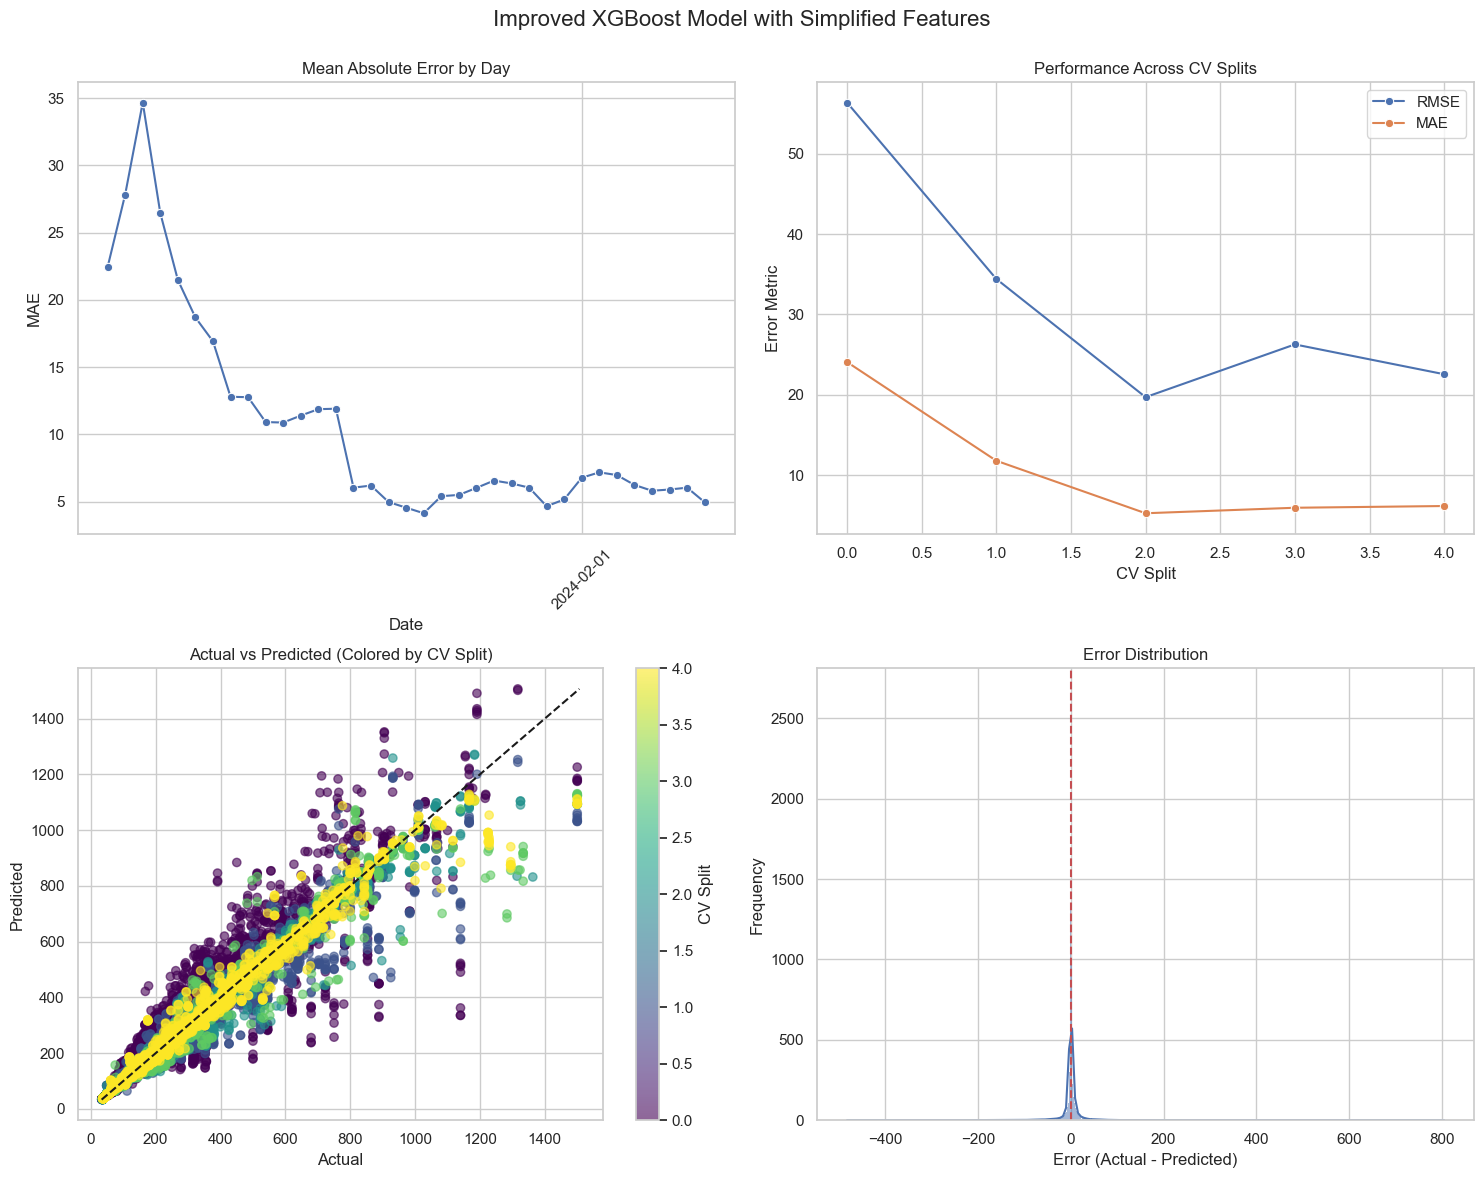

C:\Users\mvk\AppData\Local\Temp\ipykernel_20100\4066011582.py:792: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


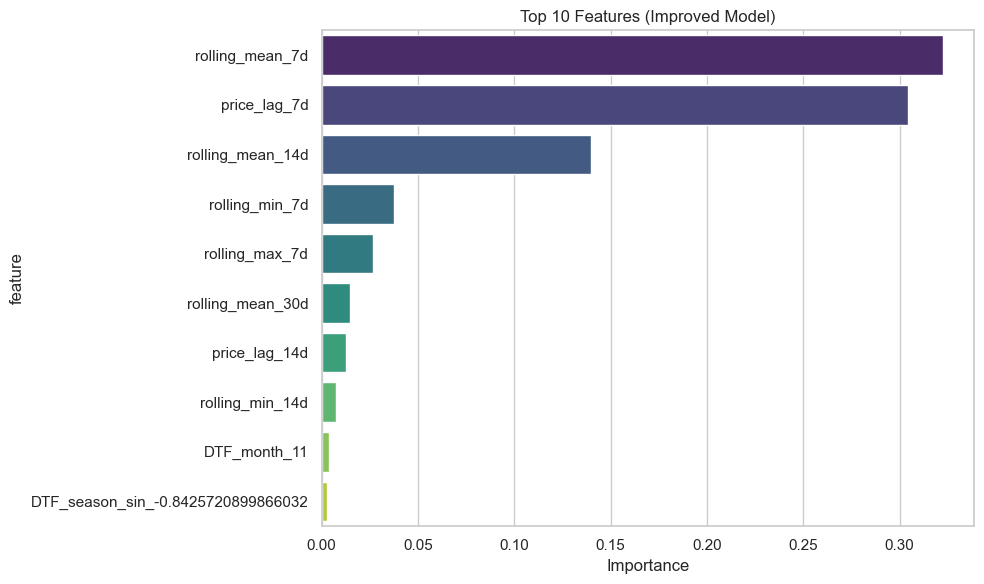

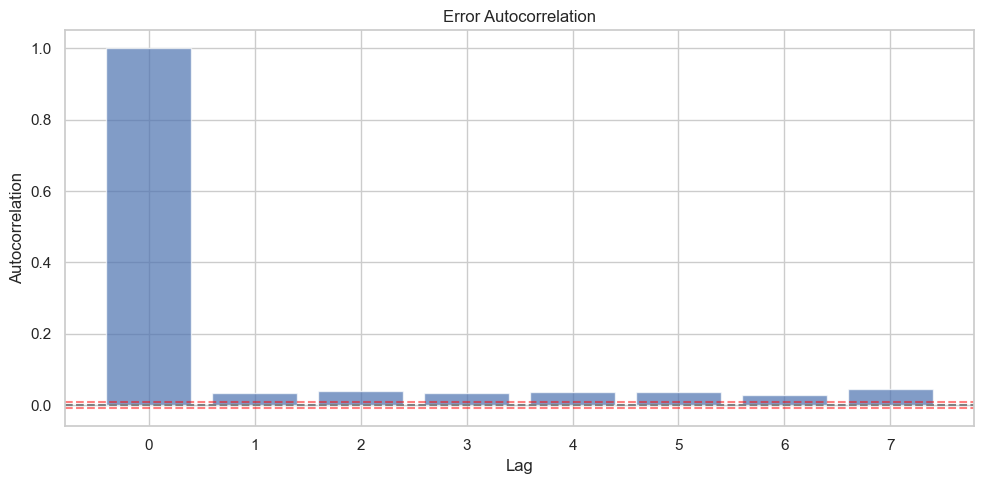

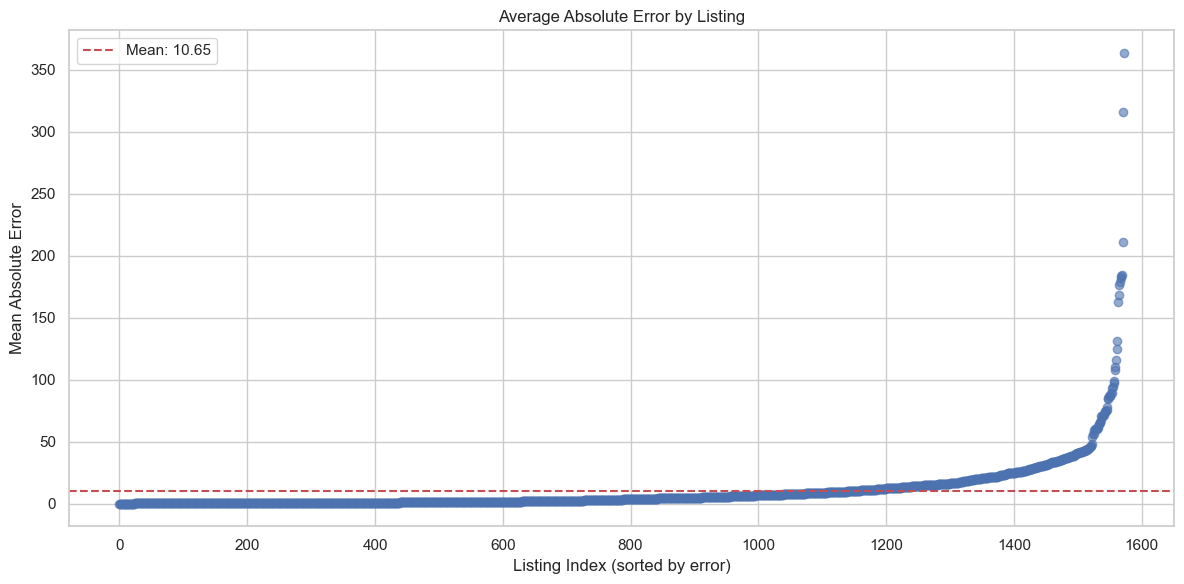

In [1]:
#with history
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from math import radians, sin, cos, sqrt, atan2
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, max_error, median_absolute_error
from scipy.stats import linregress
from statsmodels.tsa.stattools import acf
from xgboost import XGBRegressor
import math
import warnings
import matplotlib.dates as mdates


def create_advanced_spatial_features(df, k_neighbors=5, train_data_only=None):
    """
    Create both simple and advanced spatial features without using complex price information
    
    Parameters:
    -----------
    df : DataFrame
        The data to create features for
    k_neighbors : int
        Number of neighbors to use for spatial clustering
    train_data_only : DataFrame, optional
        If provided, use only this data for computing the spatial features
        This prevents data leakage by ensuring test listings don't influence each other
        
    Returns:
    --------
    DataFrame
        DataFrame containing the spatial features
    """
    # Create an explicit copy of the DataFrame to avoid SettingWithCopyWarning
    df = df.copy()
    
    # Reference data for computing spatial relationships
    reference_data = train_data_only if train_data_only is not None else df
    
    city_center_lat, city_center_lon = 48.8566, 2.3522
    
    # Basic spatial features
    spatial_data = {
        'distance_to_center': df.apply(
            lambda row: calculate_distance(
                row['latitude'], 
                row['longitude'], 
                city_center_lat, 
                city_center_lon
            ),
            axis=1
        ).values,
        'north_south': (df['latitude'] - city_center_lat).values
    }
    
    # Add more advanced spatial features
    from sklearn.neighbors import BallTree
    import numpy as np
    
    # Create latitude/longitude arrays for spatial calculation
    # In create_advanced_spatial_features:
    coords = np.radians(df[['latitude', 'longitude']].values)
    ref_coords = np.radians(reference_data[['latitude', 'longitude']].values)
    
    # Build BallTree for efficiently finding nearest neighbors
    tree = BallTree(ref_coords, metric='haversine')
    
    # Find k+1 nearest neighbors (including self)
    k_query = min(k_neighbors + 1, len(ref_coords))
    distances, indices = tree.query(coords, k=k_query)
    
    # Calculate neighborhood density (inverse of average distance to neighbors)
    # Skip the first neighbor (self)
    if k_query > 1:
        avg_neighbor_distance = np.mean(distances[:, 1:], axis=1)
        spatial_data['neighborhood_density'] = 1 / (avg_neighbor_distance + 1e-6)
    else:
        spatial_data['neighborhood_density'] = np.zeros(len(df))
    
    # Calculate the standard deviation of distances to neighbors
    if k_query > 1:
        spatial_data['neighbor_distance_std'] = np.std(distances[:, 1:], axis=1)
    else:
        spatial_data['neighbor_distance_std'] = np.zeros(len(df))
    
    # Calculate the radius covering all neighbors
    if k_query > 1:
        spatial_data['neighbor_radius'] = np.max(distances[:, 1:], axis=1)
    else:
        spatial_data['neighbor_radius'] = np.zeros(len(df))
    
    # Create DataFrame with features
    feature_df = pd.DataFrame(spatial_data, index=df.index)
    
    # Add neighborhood categorical features if they exist
    if 'neighbourhood_cleansed_encoded' in df.columns:
        feature_df['neighbourhood_encoded'] = df['neighbourhood_cleansed_encoded']
    
    # Standardize features
    for col in feature_df.columns:
        # Skip categorical neighborhood encoding
        if col == 'neighbourhood_encoded':
            continue
            
        mean_val = feature_df[col].mean()
        std_val = feature_df[col].std()
        # Avoid division by zero
        if std_val > 0:
            feature_df[col] = (feature_df[col] - mean_val) / std_val
        else:
            feature_df[col] = 0
    
    return feature_df

def calculate_distance(lat1, lon1, lat2, lon2):
    """Calculate the distance between two points using the Haversine formula."""
    R = 6371  # Earth's radius in kilometers
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c

def apply_price_transformation(train_data, inverse=False):
    """
    Apply log transformation to price data or inverse the transformation
   
    Parameters:
    -----------
    train_data : DataFrame
        The dataframe containing price data
    inverse : bool
        If True, apply inverse transformation; otherwise apply log transformation
       
    Returns:
    --------
    DataFrame
        Modified dataframe with transformed prices
    """
    df = train_data.copy()
   
    if not inverse:
        # Apply log transformation
        print("Applying log transformation to price data")
        df['original_price'] = df['price']  # Store original price
        df['price'] = np.log1p(df['price'])  # log1p to handle zero values
    else:
        # Inverse transform
        print("Inverting log transformation for predictions")
        df['price'] = np.expm1(df['price'])  # expm1 is the inverse of log1p
   
    return df

def create_simplified_features(df):
    """
    Create simplified spatial and categorical features without complex neighborhood calculations
    
    Parameters:
    -----------
    df : DataFrame
        The data to create features for
        
    Returns:
    --------
    DataFrame
        DataFrame containing the spatial and other features
    """
    # Create an explicit copy of the DataFrame to avoid SettingWithCopyWarning
    df = df.copy()
    
    city_center_lat, city_center_lon = 48.8566, 2.3522
    
    # Create basic spatial features
    spatial_data = {
        'distance_to_center': df.apply(
            lambda row: calculate_distance(
                row['latitude'], 
                row['longitude'], 
                city_center_lat, 
                city_center_lon
            ),
            axis=1
        ).values,
        'north_south': (df['latitude'] - city_center_lat).values    }
    
    # Create DataFrame with features
    feature_df = pd.DataFrame(spatial_data, index=df.index)
    
    # Standardize features
    for col in feature_df.columns:
        mean_val = feature_df[col].mean()
        std_val = feature_df[col].std()
        # Avoid division by zero
        if std_val > 0:
            feature_df[col] = (feature_df[col] - mean_val) / std_val
        else:
            feature_df[col] = 0
    
    return feature_df

def compute_error_stability_metrics(results_df):
    """
    Compute metrics related to error stability across listings and time
    
    Parameters:
    -----------
    results_df : DataFrame
        DataFrame containing prediction results with 'error', 'listing_id', 'date', etc.
        
    Returns:
    --------
    dict
        Dictionary containing error stability metrics
    """
    # Error stability over time (by day)
    daily_error_std = results_df.groupby(pd.to_datetime(results_df['date']).dt.date)['error'].std().mean()
    
    # Error stability across listings
    listing_error_std = results_df.groupby('listing_id')['error'].std().mean()
    
    # Coefficient of variation (standardized measure of dispersion)
    cv_error = results_df['error'].std() / results_df['error'].mean() if results_df['error'].mean() != 0 else float('inf')
    
    # Price segment error stability (analyze error stability across price ranges)
    # Create price buckets by percentile to ensure equal sizes
    results_df['price_bucket'] = pd.qcut(results_df['price'], q=5, labels=False)
    price_segment_error_std = results_df.groupby('price_bucket')['error'].std()
    
    # Temporal stability (correlation between consecutive days' errors)
    results_df = results_df.sort_values(['listing_id', 'date'])
    temporal_stability = results_df.groupby('listing_id').apply(
        lambda x: x['error'].autocorr() if len(x) > 1 else np.nan
    ).mean()
    
    return {
        'daily_error_std': daily_error_std,
        'listing_error_std': listing_error_std,
        'cv_error': cv_error,
        'price_segment_error_std': price_segment_error_std,
        'temporal_stability': temporal_stability
    }

def run_improved_xgboost(train_path, train_ids_path, test_ids_path, output_dir=None, window_size=35, n_splits=5, sample_size=None):    
    """
    Run improved XGBoost with simplified features for predicting prices without price history.
    Uses separate listing IDs for training and testing to prevent data leakage.
    Applies log transformation to prices during training and transforms back for evaluation.
    
    Parameters:
    -----------
    train_path : str
        Path to the training data CSV file
    train_ids_path : str
        Path to text file with training listing IDs
    test_ids_path : str
        Path to text file with test listing IDs
    output_dir : str, optional
        Directory to save results
    window_size : int, optional
        Size of the rolling window in days
    n_splits : int, optional
        Number of splits for time series cross-validation
    sample_size : int, optional
        Limit dataset to this number of random listings (for testing)
    """
    print(f"Processing dataset: {os.path.basename(train_path)}")
    
    # Load training data
    print("Loading data...")
    train_data = pd.read_csv(train_path)

    # Load listing IDs for train/test split
    print("Loading train/test listing IDs...")
    with open(train_ids_path, 'r') as f:
        train_listing_ids = [int(line.strip()) for line in f.readlines()]
        
    with open(test_ids_path, 'r') as f:
        test_listing_ids = [int(line.strip()) for line in f.readlines()]
    
    print(f"Loaded {len(train_listing_ids)} train IDs and {len(test_listing_ids)} test IDs")

    if 'simulated_price' in train_data.columns:
        print("Dropping simulated_price column from the dataset")
        train_data = train_data.drop('simulated_price', axis=1)
        
    # Apply log transformation to prices
    train_data = apply_price_transformation(train_data, inverse=False)
    
    # For testing - take only a small sample of listings if specified
    if sample_size:
        print(f"Limiting to {sample_size} random listings for testing")
        selected_train = np.random.choice(train_listing_ids, int(sample_size * 0.7), replace=False)
        selected_test = np.random.choice(test_listing_ids, int(sample_size * 0.3), replace=False)
        train_listing_ids = selected_train.tolist()
        test_listing_ids = selected_test.tolist()
    
    # Convert date column to datetime
    train_data['date'] = pd.to_datetime(train_data['date'])
    
    # Filter data to include only dates from 7/8/23 till 2/8/24 (as specified)
    start_date = pd.to_datetime('2023-07-08')
    end_date = pd.to_datetime('2024-02-08')
    train_data = train_data[(train_data['date'] >= start_date) & (train_data['date'] <= end_date)]
    
    # Check if we have data for the entire expected range
    print(f"Date range in filtered data: {train_data['date'].min()} to {train_data['date'].max()}")
    print(f"Number of days with data: {len(train_data['date'].dt.date.unique())}")

    # Get unique dates and ensure they are properly sorted
    unique_dates = sorted(train_data['date'].dt.date.unique())
    first_date = unique_dates[0]
    last_date = unique_dates[-1]

    # Check if there's a gap between the expected start date and actual first date
    if first_date > start_date.date():
        print(f"Warning: No data found between {start_date.date()} and {first_date}")
        print(f"Using available data starting from {first_date}")
    
    # Sort by date
    train_data = train_data.sort_values('date')
    
    # Create explicit test periods - last 5 weeks (35 days) split into 5 equal parts (7 days each)
    last_35_days = unique_dates[-35:]
    
    # Define explicit test periods - each 7 days
    test_periods = []
    for i in range(n_splits):
        start_idx = i * 7
        end_idx = start_idx + 7
        # Make sure we don't go beyond the available data
        if end_idx <= len(last_35_days):
            test_periods.append((last_35_days[start_idx], last_35_days[end_idx-1]))
    
    # Adjust n_splits if we couldn't create enough test periods
    n_splits = len(test_periods)
    
    print(f"Created {n_splits} test periods:")
    for i, (test_start, test_end) in enumerate(test_periods):
        print(f"  Period {i+1}: {test_start} to {test_end}")
    
    # Initialize XGBoost model with more conservative parameters
    xgb_model = XGBRegressor(
        n_estimators=800,          # More trees for better convergence
        learning_rate=0.03,        # Slower learning rate for better generalization
        max_depth=8,               # Moderate depth to balance complexity and overfitting
        min_child_weight=2,        # Slightly higher to reduce overfitting
        subsample=0.85,            # Use most but not all samples per tree
        colsample_bytree=0.8,      # Use most but not all features per tree
        colsample_bylevel=0.8,     # Use most but not all features per level
        gamma=0.1,                 # Minimum loss reduction for further tree split
        reg_alpha=0.2,             # L1 regularization (helps with feature selection)
        reg_lambda=1.5,            # L2 regularization (helps with general regularization)
        tree_method='hist',        # Faster algorithm
        random_state=42,
        early_stopping_rounds=50   # More patience
    )
    
    # Storage for results
    cv_results = []
    feature_importance_over_time = []
    
    # Run time series cross-validation using our explicit test periods
    for i, (test_start, test_end) in enumerate(test_periods):
        print(f"\nSplit {i+1}/{n_splits}")
        
        # Define training period: everything before test_start
        train_end = pd.to_datetime(test_start) - pd.Timedelta(days=1)
        train_end_date = train_end.date()
        
        print(f"Training period: {unique_dates[0]} to {train_end_date}")
        print(f"Testing period: {test_start} to {test_end}")
        
        # Split by date first
        train_date_mask = train_data['date'].dt.date <= train_end_date
        test_date_mask = (train_data['date'].dt.date >= test_start) & (train_data['date'].dt.date <= test_end)
        
        date_filtered_train = train_data[train_date_mask]
        date_filtered_test = train_data[test_date_mask]
        
        # Now further split by listing IDs
        train_id_mask = date_filtered_train['listing_id'].isin(train_listing_ids)
        test_id_mask = date_filtered_test['listing_id'].isin(test_listing_ids)
        
        split_train_data = date_filtered_train[train_id_mask]
        split_test_data = date_filtered_test[test_id_mask]
        
        print(f"Train data: {len(split_train_data)} rows, {len(split_train_data['listing_id'].unique())} unique listings")
        print(f"Test data: {len(split_test_data)} rows, {len(split_test_data['listing_id'].unique())} unique listings")
        
                # Create simplified spatial features
        train_spatial = create_advanced_spatial_features(
            split_train_data, 
            k_neighbors=5,
            train_data_only=date_filtered_train[train_id_mask]  # Use only training data as reference
        )
        test_spatial = create_advanced_spatial_features(
            split_test_data,
            k_neighbors=5, 
            train_data_only=date_filtered_train[train_id_mask]  # Use only training data as reference
        )
        
        # Define columns to exclude from training features
        exclude_cols = ['listing_id', 'date', 'price', 'original_price']
        
        # Filter out columns that don't exist
        exclude_cols = [col for col in exclude_cols if col in split_train_data.columns]
        
        # Get categorical and time features (including those with DTF prefix)
        dtf_columns = [col for col in split_train_data.columns if col.startswith('DTF_')]
        print(f"Found time feature columns: {dtf_columns}")
        
        # Prepare feature matrices
        # 1. Core features (without excluded columns)
        X_train_parts = [split_train_data.drop(exclude_cols, axis=1)]
        X_test_parts = [split_test_data.drop(exclude_cols, axis=1)]
        
        # 2. Add spatial features
        X_train_parts.append(train_spatial)
        X_test_parts.append(test_spatial)
        
        # 3. Create dummy variables for categorical features
        for dtf_col in dtf_columns:
            if dtf_col in split_train_data.columns and dtf_col in split_test_data.columns:
                # Create dummies and add as separate DataFrames
                train_dummies = pd.get_dummies(split_train_data[dtf_col], prefix=dtf_col)
                test_dummies = pd.get_dummies(split_test_data[dtf_col], prefix=dtf_col)
                
                X_train_parts.append(train_dummies)
                X_test_parts.append(test_dummies)
        
        # Combine all features
        X_train = pd.concat(X_train_parts, axis=1)
        X_test = pd.concat(X_test_parts, axis=1)
        
        y_train = split_train_data['price']  # This is log-transformed price
        y_test = split_test_data['price']    # This is log-transformed price
        
        # Store original prices for later evaluation
        y_test_original = split_test_data['original_price'].values
        
        # Handle missing columns in a more efficient way
        train_cols = set(X_train.columns)
        test_cols = set(X_test.columns)

        # Add missing columns to X_test
        if train_cols - test_cols:
            missing_df = pd.DataFrame(0, index=X_test.index, columns=list(train_cols - test_cols))
            X_test = pd.concat([X_test, missing_df], axis=1)

        # Add missing columns to X_train
        if test_cols - train_cols:
            missing_df = pd.DataFrame(0, index=X_train.index, columns=list(test_cols - train_cols))
            X_train = pd.concat([X_train, missing_df], axis=1)

        # Ensure the columns are in the same order
        X_test = X_test[X_train.columns]
        
        # Train the model
        print(f"Training on {len(X_train)} samples with {X_train.shape[1]} features")
        print(f"Testing on {len(X_test)} samples")
        
        # Print a sample of feature names
        print(f"Sample feature names: {list(X_train.columns[:5])}")
        
        xgb_model.fit(
            X_train, 
            y_train,
            eval_set=[(X_test, y_test)],
            verbose=False
        )
        
        # Make predictions (still in log-transformed space)
        y_pred_log = xgb_model.predict(X_test)
        
        # Create a temporary dataframe to transform predictions back
        temp_pred_df = pd.DataFrame({'price': y_pred_log})
        temp_pred_df = apply_price_transformation(temp_pred_df, inverse=True)
        y_pred = temp_pred_df['price'].values
        
        # Store feature importance
        feature_importance = pd.DataFrame({
            'feature': X_train.columns,
            'importance': xgb_model.feature_importances_,
            'split': i
        })
        feature_importance_over_time.append(feature_importance)
        
        # Calculate metrics using the original price scale
        rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
        mae = mean_absolute_error(y_test_original, y_pred)
        r2 = r2_score(y_test_original, y_pred) if len(set(y_test_original)) > 1 else np.nan
        with np.errstate(divide='ignore', invalid='ignore'):
            mape = np.mean(np.abs((y_test_original - y_pred) / (y_test_original + 1e-8))) * 100
        
        print(f"Split {i+1} Results - RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}, MAPE: {mape:.2f}%")
        
        # Store results for this split
        split_results = pd.DataFrame({
            'split': i,
            'date': split_test_data['date'],
            'listing_id': split_test_data['listing_id'],
            'price': y_test_original,  # Original price scale
            'predicted': y_pred,       # Original price scale
            'error': y_test_original - y_pred,
            'abs_error': np.abs(y_test_original - y_pred),
            'pct_error': np.abs((y_test_original - y_pred) / (y_test_original + 1e-8)) * 100
        })
        
        cv_results.append(split_results)
    
    # Combine all results
    all_results = pd.concat(cv_results, ignore_index=True)
    all_feature_importance = pd.concat(feature_importance_over_time, ignore_index=True)
    
    # Calculate overall metrics
    y_true = all_results['price']  # This is in original price scale from our changes above
    y_pred = all_results['predicted']  # This is in original price scale from our changes above
    
    overall_metrics = {
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'mae': mean_absolute_error(y_true, y_pred),
        'r2': r2_score(y_true, y_pred),
        'mape': np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100,
        'explained_variance': explained_variance_score(y_true, y_pred),
        'max_error': max_error(y_true, y_pred),
        'median_absolute_error': median_absolute_error(y_true, y_pred)
    }
    
    # Calculate split-level metrics
    split_metrics = []
    for split in range(n_splits):
        split_data = all_results[all_results['split'] == split]
        if not split_data.empty:
            y_true_split = split_data['price']
            y_pred_split = split_data['predicted']
            
            split_metrics.append({
                'split': split,
                'rmse': np.sqrt(mean_squared_error(y_true_split, y_pred_split)),
                'mae': mean_absolute_error(y_true_split, y_pred_split),
                'r2': r2_score(y_true_split, y_pred_split) if len(set(y_true_split)) > 1 else np.nan,
                'mape': np.mean(np.abs((y_true_split - y_pred_split) / (y_true_split + 1e-8))) * 100,
                'n_samples': len(y_true_split)
            })
    
    split_metrics_df = pd.DataFrame(split_metrics)
    
    # Calculate daily metrics
    all_results['date_str'] = pd.to_datetime(all_results['date']).dt.strftime('%Y-%m-%d')
    
    daily_metrics = []
    for day, group in all_results.groupby('date_str'):
        y_true_day = group['price']
        y_pred_day = group['predicted']
        
        daily_metrics.append({
            'date': day,
            'rmse': np.sqrt(mean_squared_error(y_true_day, y_pred_day)),
            'mae': mean_absolute_error(y_true_day, y_pred_day),
            'r2': r2_score(y_true_day, y_pred_day) if len(set(y_true_day)) > 1 else np.nan,
            'mape': np.mean(np.abs((y_true_day - y_pred_day) / (y_true_day + 1e-8))) * 100,
            'n_samples': len(y_true_day)
        })
    
    daily_metrics_df = pd.DataFrame(daily_metrics)
    daily_metrics_df['date'] = pd.to_datetime(daily_metrics_df['date'])
    daily_metrics_df = daily_metrics_df.sort_values('date')
    
    # Calculate error stability metrics
    error_stability = compute_error_stability_metrics(all_results)
    
    # Calculate MAE stability coefficient
    mae_stability = daily_metrics_df['mae'].std() / daily_metrics_df['mae'].mean()
    print(f"MAE Stability (CV of daily MAE): {mae_stability:.4f}")
    
    # Add to error_stability dictionary
    error_stability['mae_stability'] = mae_stability
    
    # Error analysis - autocorrelation
    errors = all_results['error'].values
    error_autocorr = acf(errors, nlags=7)[1:]  # Exclude lag 0
    
    # Create a results dictionary
    evaluation_results = {
        'overall_metrics': overall_metrics,
        'split_metrics': split_metrics_df,
        'daily_metrics': daily_metrics_df,
        'all_results': all_results,
        'feature_importance': all_feature_importance,
        'error_autocorrelation': error_autocorr,
        'error_stability': error_stability,
        'train_listings': len(train_listing_ids),
        'test_listings': len(test_listing_ids)
    }
    
    # Save results if output directory is provided
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        
        # Save all results
        results_file = os.path.join(output_dir, 'improved_xgboost_results.csv')
        all_results.to_csv(results_file, index=False)
        print(f"Results saved to {results_file}")
        
        # Save metrics
        metrics_file = os.path.join(output_dir, 'improved_xgboost_metrics.csv')
        daily_metrics_df.to_csv(metrics_file, index=False)
        print(f"Daily metrics saved to {metrics_file}")
        
        # Save feature importance
        importance_file = os.path.join(output_dir, 'improved_xgboost_feature_importance.csv')
        all_feature_importance.to_csv(importance_file, index=False)
        print(f"Feature importance saved to {importance_file}")
        
        # Save summary
        with open(os.path.join(output_dir, 'improved_summary.txt'), 'w') as f:
            f.write(f"Improved XGBoost Model Summary (Simplified Features)\n")
            f.write(f"===================================================\n\n")
            f.write(f"Number of splits: {n_splits}\n")
            f.write(f"Training period: {unique_dates[0]} to {unique_dates[-1]}\n")
            f.write(f"Number of training listings: {len(train_listing_ids)}\n")
            f.write(f"Number of test listings: {len(test_listing_ids)}\n\n")
            f.write(f"Overall Metrics (on original price scale):\n")
            f.write(f"  MAE Stability (day-to-day): {error_stability.get('mae_stability', float('nan')):.4f}\n")
            for k, v in overall_metrics.items():
                f.write(f"  {k}: {v:.6f}\n")
    
    # Print summary
    print_summary(evaluation_results)
    
    # Create plots
    plot_results(evaluation_results)
    
    return evaluation_results

def print_summary(evaluation_results):
    """Print a summary of the improved model results"""
    overall = evaluation_results['overall_metrics']
    splits = evaluation_results['split_metrics']
    daily = evaluation_results['daily_metrics']
    feature_importance = evaluation_results['feature_importance']
    error_autocorr = evaluation_results.get('error_autocorrelation', [0] * 7)
    
    # Print new info about listing splits if available
    train_listings = evaluation_results.get('train_listings', 'N/A')
    test_listings = evaluation_results.get('test_listings', 'N/A')
    
    print("\n===== IMPROVED XGBOOST MODEL WITH SIMPLIFIED FEATURES =====")
    if train_listings != 'N/A':
        print(f"Using {train_listings} listings for training and {test_listings} listings for testing")
    
    print("\n=== Overall Metrics ===")
    print(f"RMSE: {overall['rmse']:.4f}")
    print(f"MAE: {overall['mae']:.4f}")
    print(f"R²: {overall['r2']:.4f}")
    print(f"MAPE: {overall['mape']:.4f}%")
    print(f"Explained Variance: {overall['explained_variance']:.4f}")
    print(f"Median Abs Error: {overall['median_absolute_error']:.4f}")
    
    print("\n=== Split Performance ===")
    print(splits[['split', 'rmse', 'mae', 'mape', 'r2', 'n_samples']].to_string(index=False))
    
    print("\n=== Split Statistics ===")
    print("MAE:")
    print(f"  Average: {splits['mae'].mean():.4f}")
    print(f"  Min: {splits['mae'].min():.4f} (Split {splits.loc[splits['mae'].idxmin(), 'split']})")
    print(f"  Max: {splits['mae'].max():.4f} (Split {splits.loc[splits['mae'].idxmax(), 'split']})")
    
    print("\nRMSE:")
    print(f"  Average: {splits['rmse'].mean():.4f}")
    print(f"  Min: {splits['rmse'].min():.4f} (Split {splits.loc[splits['rmse'].idxmin(), 'split']})")
    print(f"  Max: {splits['rmse'].max():.4f} (Split {splits.loc[splits['rmse'].idxmax(), 'split']})")
    
    # Calculate RMSE for later folds (excluding fold 1)
    later_folds = splits[splits['split'] > 0]
    later_rmse = later_folds['rmse'].mean()
    print(f"  Later folds RMSE (excl. fold 1): {later_rmse:.4f}")
    
    print("\n=== Error Autocorrelation ===")
    for lag, acf_value in enumerate(error_autocorr, 1):
        print(f"  Lag {lag}: {acf_value:.4f}")
    
    # Add this after printing the error autocorrelation
    print("\n=== Error Stability Metrics ===")
    stability = evaluation_results.get('error_stability', {})
    if stability:
        print(f"Daily Error Std Dev: {stability['daily_error_std']:.4f}")
        print(f"Listing Error Std Dev: {stability['listing_error_std']:.4f}")
        print(f"Coefficient of Variation of Error: {stability['cv_error']:.4f}")
        print(f"Temporal Stability (autocorr): {stability['temporal_stability']:.4f}")
        print(f"MAE Stability (day-to-day): {stability.get('mae_stability', float('nan')):.4f}")
        print("\nPrice Segment Error Std Dev:")
        for bucket, std_val in stability['price_segment_error_std'].items():
            price_segment = ['Very Low', 'Low', 'Medium', 'High', 'Very High'][bucket]
            print(f"  {price_segment}: {std_val:.4f}")

    # Calculate overall feature importance by averaging across splits
    avg_importance = feature_importance.groupby('feature')['importance'].mean().reset_index()
    top_features = avg_importance.sort_values('importance', ascending=False).head(10)
    
    print("\n=== Top 10 Most Important Features (Simplified Model) ===")
    for i, (_, row) in enumerate(top_features.iterrows(), 1):
        print(f"{i}. {row['feature']}: {row['importance']:.6f}")

def plot_results(evaluation_results):
    """Plot the results from the improved model"""
    # Set style
    sns.set_theme(style="whitegrid")
    
    # Extract data
    daily_metrics = evaluation_results['daily_metrics']
    all_results = evaluation_results['all_results']
    splits = evaluation_results['split_metrics']
    
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Add title showing we're using the improved model
    fig.suptitle('Improved XGBoost Model with Simplified Features', fontsize=16)
    
    # Plot 1: Daily MAE
    sns.lineplot(
        x=pd.to_datetime(daily_metrics['date']),
        y=daily_metrics['mae'],
        marker='o',
        ax=axes[0, 0]
    )
    axes[0, 0].set_title('Mean Absolute Error by Day')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('MAE')
    axes[0, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    axes[0, 0].xaxis.set_major_locator(mdates.MonthLocator())
    plt.setp(axes[0, 0].xaxis.get_majorticklabels(), rotation=45)
    
    # Plot 2: Cross-validation splits performance
    splits_x = splits['split']
    metrics_to_plot = ['rmse', 'mae']
    
    for metric in metrics_to_plot:
        sns.lineplot(
            x=splits_x,
            y=splits[metric],
            marker='o',
            label=metric.upper(),
            ax=axes[0, 1]
        )
    
    axes[0, 1].set_title('Performance Across CV Splits')
    axes[0, 1].set_xlabel('CV Split')
    axes[0, 1].set_ylabel('Error Metric')
    axes[0, 1].legend()
    
    # Plot 3: Actual vs Predicted (colored by split)
    scatter = axes[1, 0].scatter(
        all_results['price'],
        all_results['predicted'],
        c=all_results['split'],
        alpha=0.6,
        cmap='viridis'
    )
    min_val = min(all_results['price'].min(), all_results['predicted'].min())
    max_val = max(all_results['price'].max(), all_results['predicted'].max())
    axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'k--')
    axes[1, 0].set_title('Actual vs Predicted (Colored by CV Split)')
    axes[1, 0].set_xlabel('Actual')
    axes[1, 0].set_ylabel('Predicted')
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=axes[1, 0])
    cbar.set_label('CV Split')
    
    # Plot 4: Error distribution
    sns.histplot(all_results['error'], kde=True, ax=axes[1, 1])
    axes[1, 1].axvline(0, color='r', linestyle='--')
    axes[1, 1].set_title('Error Distribution')
    axes[1, 1].set_xlabel('Error (Actual - Predicted)')
    axes[1, 1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)  # Make room for the suptitle
    plt.show()
    
    # Create plot for feature importance
    feature_importance = evaluation_results['feature_importance']
    top_features = feature_importance.groupby('feature')['importance'].mean().nlargest(10)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x=top_features.values,
        y=top_features.index,
        palette='viridis'
    )
    plt.title('Top 10 Features (Improved Model)')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()
    
    # Plot error autocorrelation
    error_acf = np.concatenate([[1], evaluation_results['error_autocorrelation']])
    lags = range(len(error_acf))
    
    plt.figure(figsize=(10, 5))
    plt.bar(lags, error_acf, alpha=0.7)
    plt.axhline(y=0, linestyle='--', color='gray')
    
    # Add confidence intervals (95%)
    conf_interval = 1.96 / np.sqrt(len(all_results['error']))
    plt.axhline(y=conf_interval, linestyle='--', color='red', alpha=0.5)
    plt.axhline(y=-conf_interval, linestyle='--', color='red', alpha=0.5)
    
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.title('Error Autocorrelation')
    plt.tight_layout()
    plt.show()
    
    # Additional plot: Performance by listing ID count
    # Group by listing ID and calculate average absolute error for each listing
    listing_errors = all_results.groupby('listing_id')['abs_error'].mean().reset_index()
    listing_errors = listing_errors.sort_values('abs_error')
    
    plt.figure(figsize=(12, 6))
    plt.scatter(range(len(listing_errors)), listing_errors['abs_error'], alpha=0.6)
    plt.axhline(y=listing_errors['abs_error'].mean(), color='r', linestyle='--', 
                label=f'Mean: {listing_errors["abs_error"].mean():.2f}')
    plt.title('Average Absolute Error by Listing')
    plt.xlabel('Listing Index (sorted by error)')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    train_path = r"C:\Users\mvk\Documents\DATA_school\thesis\Subset\top_price_changers_subset\train_up3.csv"
    train_ids_path = r"C:\Users\mvk\Documents\DATA_school\thesis\Subset\top_price_changers_subset\train_ids.txt"
    test_ids_path = r"C:\Users\mvk\Documents\DATA_school\thesis\Subset\top_price_changers_subset\test_ids.txt"
    
    # Output directory
    output_dir = ".\output\improved_xgboost"
    
    # Run the model
    results = run_improved_xgboost(
        train_path=train_path,
        train_ids_path=train_ids_path,
        test_ids_path=test_ids_path,
        output_dir=output_dir,
        window_size=35,  # 5 weeks
        n_splits=5,
        sample_size=None  # Set to a number like 1000 for testing, None to use all data
    )